In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
from google.colab import files
files.upload()

Saving medical-mnist.zip to medical-mnist.zip


In [3]:
!unzip medical-mnist.zip -d medical-mnist

Streaming output truncated to the last 5000 lines.
  inflating: medical-mnist/HeadCT/005000.jpeg  
  inflating: medical-mnist/HeadCT/005001.jpeg  
  inflating: medical-mnist/HeadCT/005002.jpeg  
  inflating: medical-mnist/HeadCT/005003.jpeg  
  inflating: medical-mnist/HeadCT/005004.jpeg  
  inflating: medical-mnist/HeadCT/005005.jpeg  
  inflating: medical-mnist/HeadCT/005006.jpeg  
  inflating: medical-mnist/HeadCT/005007.jpeg  
  inflating: medical-mnist/HeadCT/005008.jpeg  
  inflating: medical-mnist/HeadCT/005009.jpeg  
  inflating: medical-mnist/HeadCT/005010.jpeg  
  inflating: medical-mnist/HeadCT/005011.jpeg  
  inflating: medical-mnist/HeadCT/005012.jpeg  
  inflating: medical-mnist/HeadCT/005013.jpeg  
  inflating: medical-mnist/HeadCT/005014.jpeg  
  inflating: medical-mnist/HeadCT/005015.jpeg  
  inflating: medical-mnist/HeadCT/005016.jpeg  
  inflating: medical-mnist/HeadCT/005017.jpeg  
  inflating: medical-mnist/HeadCT/005018.jpeg  
  inflating: medical-mnist/HeadCT/005

In [4]:
import os
DATA_DIR = "./medical-mnist"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)


Found 47164 images belonging to 6 classes.
Found 11790 images belonging to 6 classes.


In [5]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices()

Num GPUs Available: 1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the base layers first
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,815,078 (83.22 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [7]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 712s 472ms/step - accuracy: 0.9485 - loss: 0.1637 - val_accuracy: 0.9966 - val_loss: 0.0124
Epoch 2/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 684s 464ms/step - accuracy: 0.9952 - loss: 0.0157 - val_accuracy: 0.9975 - val_loss: 0.0069
Epoch 3/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 677s 459ms/step - accuracy: 0.9952 - loss: 0.0138 - val_accuracy: 0.9972 - val_loss: 0.0084
Epoch 4/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 674s 458ms/step - accuracy: 0.9961 - loss: 0.0116 - val_accuracy: 0.9980 - val_loss: 0.0044
Epoch 5/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 679s 461ms/step - accuracy: 0.9958 - loss: 0.0117 - val_accuracy: 0.9983 - val_loss: 0.0044


In [9]:
# Training first layer first

for layer in base_model.layers[-100:]:  # unfreeze last 100 layers
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=3
)


Epoch 1/3
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 739s 479ms/step - accuracy: 0.9796 - loss: 0.0615 - val_accuracy: 0.9992 - val_loss: 0.0026
Epoch 2/3
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 681s 462ms/step - accuracy: 0.9989 - loss: 0.0039 - val_accuracy: 0.9992 - val_loss: 0.0027
Epoch 3/3
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 687s 466ms/step - accuracy: 0.9990 - loss: 0.0026 - val_accuracy: 0.9996 - val_loss: 0.0018


In [10]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


369/369 ━━━━━━━━━━━━━━━━━━━━ 137s 371ms/step - accuracy: 0.9999 - loss: 3.6757e-04
Validation Accuracy: 99.97%


369/369 ━━━━━━━━━━━━━━━━━━━━ 144s 375ms/step


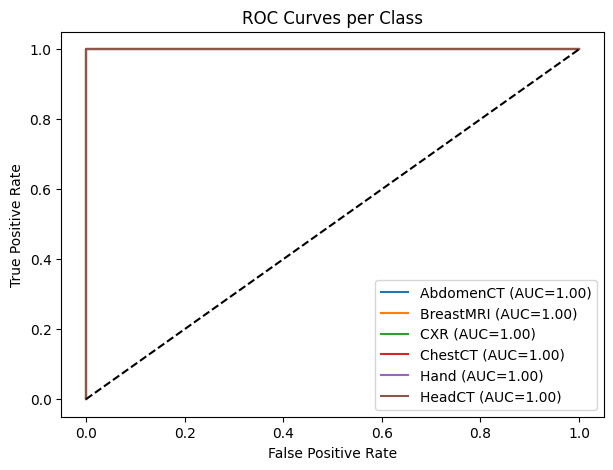

In [11]:
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_score = np.array(y_pred)

fpr, tpr, roc_auc = {}, {}, {}
for i, c in enumerate(val_gen.class_indices):
    fpr[c], tpr[c], _ = roc_curve((y_true == i).astype(int), y_score[:, i])
    roc_auc[c] = auc(fpr[c], tpr[c])

plt.figure(figsize=(7,5))
for c in roc_auc:
    plt.plot(fpr[c], tpr[c], label=f"{c} (AUC={roc_auc[c]:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(); plt.title('ROC Curves per Class')
plt.show()


369/369 ━━━━━━━━━━━━━━━━━━━━ 145s 376ms/step


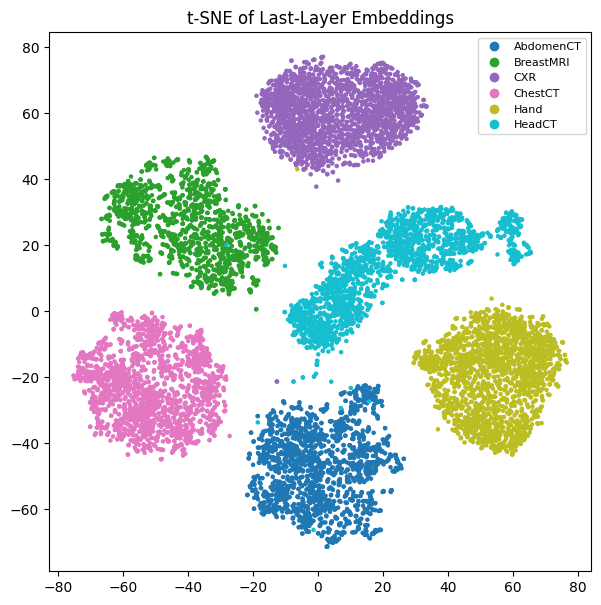

In [12]:
from sklearn.manifold import TSNE

# Extract features from the penultimate layer
feature_model = Model(inputs=model.input, outputs=model.layers[-2].output)
features = feature_model.predict(val_gen)
labels = y_true

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb = tsne.fit_transform(features)

plt.figure(figsize=(7,7))
scatter = plt.scatter(emb[:,0], emb[:,1], c=labels, cmap='tab10', s=5)
plt.legend(handles=scatter.legend_elements()[0], labels=val_gen.class_indices.keys(), fontsize=8)
plt.title('t-SNE of Last-Layer Embeddings')
plt.show()


# Writeup:

## 1. Model Selection
I chose InceptionV3, becuase_
- It was one of the first ImageNet architectures successfully adapted to medical imaging tasks.
- It trains efficiently on a Google Colab GPU.
- Keras provides a simple and stable API for transfer learning and fine-tuning.

---

## 2. Dataset Selection
I used the **Medical MNIST** dataset from Kaggle. It contains 10,000 grayscale medical images across six classes:

- Abdomen CT  
- Breast MRI  
- Chest X-ray  
- Chest CT  
- Hand X-ray  
- Head CT  

Reasons for choosing this dataset:
- Small size and quick to train.
- Balanced classes.
- Well-suited for transfer learning demonstrations.
- Simple directory structure that works directly with Keras data generators.

All images were resized to **224×224×3** to match InceptionV3 input requirements.

---

## 3. Methodology

### Preprocessing
- Loaded dataset using `ImageDataGenerator`.
- Rescaled pixel intensities to [0, 1].
- Applied data augmentation (rotation, zoom, horizontal flip).
- Used an 80/20 training/validation split.

### Model Architecture
- Loaded InceptionV3 with `weights="imagenet"` and `include_top=False`.
- Added:
  - `GlobalAveragePooling2D`
  - `Dropout(0.4)`
  - Dense softmax output layer with 6 units (one per class)

### Training Procedure

**Stage 1: Train only the classification head**
- All convolutional layers frozen  
- 5 epochs  
- Optimizer: Adam (learning rate 1e-3)

**Stage 2: Fine-tune the pretrained base**
- Unfroze the last 100 layers of InceptionV3  
- 5 additional epochs  
- Optimizer: Adam (learning rate 1e-5)


---

## 4. Results

**Validation Accuracy after fine-tuning:** 99.7%
